## 1.Importing the Libraries & Pre-Processing Steps

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter

### 2. Get the Device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
print(f"Using Device: {device}")

Using Device: cpu


### 3. Set the Seed

In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

### 4. Hyperparameters

In [5]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4    #We segment our Images into patches of size 4
NUM_CLASSES = 10  #Number of classes in the Cifar-10 Dataset
IMG_SIZE = 32
IMG_CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
NUM_BLOCKS_DEPTH = 6 #Number of transformers block
MLP_DIM = 512
DROPOUT_RATE = 0.1



### 5. Image Transformations

In [6]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]
)

### 6. Get the Dataset

In [7]:
train_dataset = datasets.CIFAR10(root="dataset", train=True,download=True, transform=transforms)
test_dataset = datasets.CIFAR10(root="dataset", train=False, download=True, transform=transforms)

100%|██████████| 170498071/170498071 [00:17<00:00, 9664322.73it/s] 


Extracting dataset\cifar-10-python.tar.gz to dataset
Files already downloaded and verified


In [8]:
print(f"Successfully downloaded train_dataset of length:- {len(train_dataset)}")
print(f"Successfully downloaded test_dataset of length:- {len(test_dataset)}")

Successfully downloaded train_dataset of length:- 50000
Successfully downloaded test_dataset of length:- 10000


### 7. Get the DataLoaders
- It converts our dataset into batches so that the training of our model becomes computationally more efficient.

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
print(f"Successfully created DataLoader for train_dataset:- {len(train_loader)} batches of size {BATCH_SIZE}")
print(f"Successfully created DataLoader for test_dataset:- {len(test_loader)} batches of size {BATCH_SIZE}")

Successfully created DataLoader for train_dataset:- 391 batches of size 128
Successfully created DataLoader for test_dataset:- 79 batches of size 128


## Vision Transformer Architecture

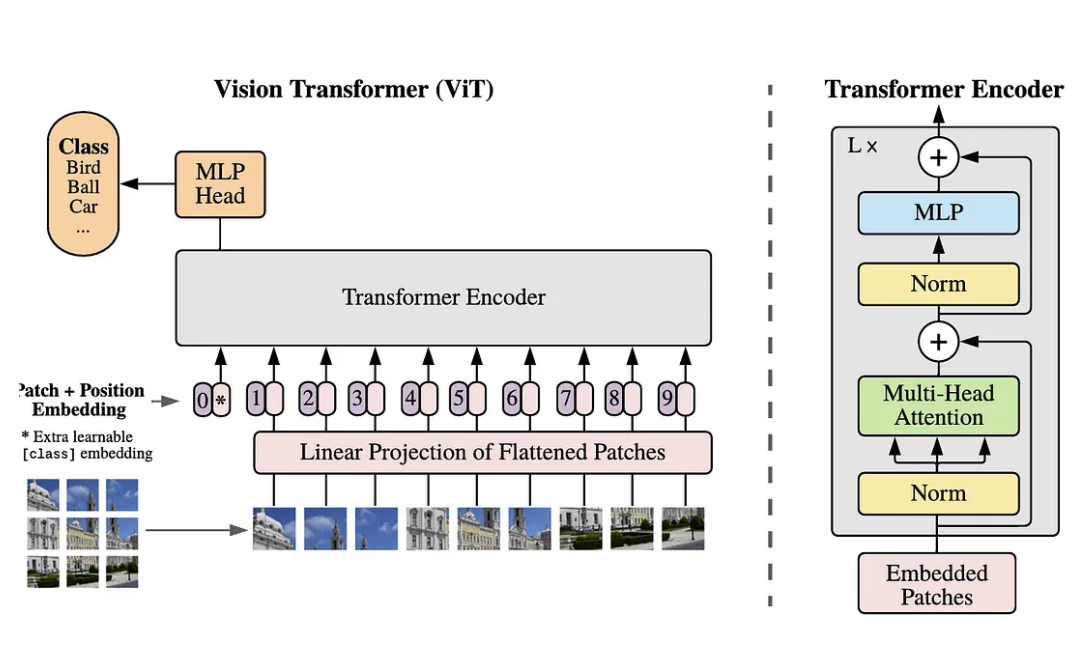

### 1. PatchEmbedding Class Implementation

In [11]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, embed_dim):
    super().__init__()
    self.patch_size = patch_size

    #This project each patch to a vector of length of Embed_dim
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels=embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size) ** 2

    #It is a learnable parameter that is initialized randomly and gets updated during the training and is used for classification.
    self.cls_token = nn.Parameter(torch.randn(1, 1 , embed_dim))

    #It is a learnable parameter that is initialized randomly and gets updated during the training and is used to provide spatial_information/positional_information to the model
    self.pos_embed = nn.Parameter(torch.randn(1, 1+num_patches,embed_dim))

  def forward(self, x:torch.Tensor):
    B = x.size(0) #Batch Size
    x = self.proj(x)  # (Batch_size, Embed_dim, H/P, W/P)
    x = x.flatten(2).transpose(1,2) #(Batch_size, Embed_dim, H/P, W/P)--------->(Batch_size,Embed_dim,N)-------->(Batch_size,N,Embed_dim)
    cls_token = self.cls_token.expand(B, -1,-1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embed  #Add positional embedding to the output

    return x


### 2. Multi-Layer Perceptron Implementation

In [12]:
class MLP(nn.Module):
  def __init__(self,in_features, hidden_features, drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features,hidden_features)
    self.fc2 = nn.Linear(hidden_features, in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x

### 3. Transformer Encoder Implementation

In [13]:
class Encoder(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout = drop_rate, batch_first = True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

### 4. VisionTransformer Implementation

In [14]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels,num_classes, embed_dim, depth, num_heads ,mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(
        *[Encoder(embed_dim, num_heads, mlp_dim, drop_rate) for _ in range(depth)]
    )
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)


### 5. Instantiate Model

In [15]:
model = VisionTransformer(
    IMG_SIZE,PATCH_SIZE,IMG_CHANNELS,NUM_CLASSES,EMBED_DIM,
    NUM_BLOCKS_DEPTH,NUM_HEADS,MLP_DIM,DROPOUT_RATE
).to(device)

In [16]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): Encoder(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Encoder(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_featu

### 6. Define a Loss function & an Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

## Training Loop

### Train Function

In [18]:
def train(model, train_loader, optimizer, criterion):
  #Set the model in training mode
  model.train()

  total_loss, correct = 0,0

  for batch_img,batch_label in train_loader:
    #Move the data to same device
    batch_img, batch_label = batch_img.to(device), batch_label.to(device)

    #Step 1.Reset the gradients
    optimizer.zero_grad()

    #Step 2. Do the forward pass{i.e give input image to model so that it can output logits of multiple classes}
    output = model(batch_img)

    #Step 3. Calculate the Loss
    loss = criterion(output,batch_label)

    #Step 4. Do Backpropagation of loss so that our gradients can be updated
    loss.backward()

    #Step 5. Perform Gradient Descent Algorithm so that our gradients are updated
    optimizer.step()

    #Step 6. Update the total_loss and correct values
    total_loss += loss.item() * batch_img.size(0)
    correct += (output.argmax(1) == batch_label).sum().item()  #It will take all the correct predictions for the batch and sum it

  #Step 7. Return the (total_loss , correct) normalized according to the dataset
  return total_loss/len(train_loader.dataset) , correct/len(train_loader.dataset)



### Evaluation Function

In [19]:
def evaluate(model, test_loader):
  #Set the model into evaluation mode
  model.eval()
  correct = 0
  for batch_img, batch_label in test_loader:
    batch_img, batch_label = batch_img.to(device), batch_label.to(device)
    pred = model(batch_img)
    correct += (pred.argmax(1) == batch_label).sum().item()

  return correct / len(test_loader.dataset)



### Training


In [20]:
#Initialize Writer to log results to TensorBoard
writer = SummaryWriter(log_dir="runs/ViT")

In [21]:
train_accuracies , test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  #Log metrics to Tensorboard
  writer.add_scalar("Loss/Train", train_loss,epoch)
  writer.add_scalar("Accuracy/Train", train_acc, epoch)
  writer.add_scalar("Accuracy/Test", test_acc, epoch)

  print(f"EPOCH: [{epoch + 1}/{EPOCHS}], Train-Loss: [{train_loss:.4f}], Train-Accuracy: [{(train_acc * 100):.3f}%], Test-Accuracy: [{(test_acc * 100):.3f}%]")

#Close the writer
writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: [1/10], Train-Loss: [1.7387], Train-Accuracy: [36.976%], Test-Accuracy: [47.010%]
EPOCH: [2/10], Train-Loss: [1.3869], Train-Accuracy: [50.320%], Test-Accuracy: [53.010%]
EPOCH: [3/10], Train-Loss: [1.2348], Train-Accuracy: [55.696%], Test-Accuracy: [57.080%]
EPOCH: [4/10], Train-Loss: [1.1359], Train-Accuracy: [59.416%], Test-Accuracy: [58.730%]
EPOCH: [5/10], Train-Loss: [1.0492], Train-Accuracy: [62.414%], Test-Accuracy: [60.930%]
EPOCH: [6/10], Train-Loss: [0.9655], Train-Accuracy: [65.590%], Test-Accuracy: [60.690%]
EPOCH: [7/10], Train-Loss: [0.8909], Train-Accuracy: [68.342%], Test-Accuracy: [61.600%]
EPOCH: [8/10], Train-Loss: [0.8214], Train-Accuracy: [70.620%], Test-Accuracy: [63.570%]
EPOCH: [9/10], Train-Loss: [0.7456], Train-Accuracy: [73.308%], Test-Accuracy: [63.130%]
EPOCH: [10/10], Train-Loss: [0.6743], Train-Accuracy: [75.948%], Test-Accuracy: [62.340%]


#### Save Model Weights

In [22]:
import os
os.makedirs("weights", exist_ok=True)

In [23]:
torch.save(model.state_dict(), "weights/model.pt")

### Plot the Graph for accuracies

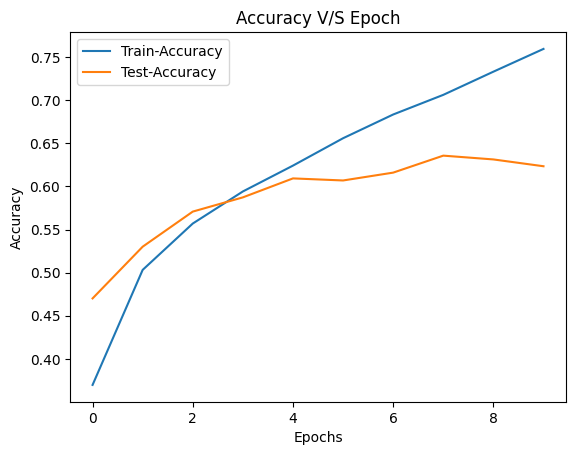

In [24]:
plt.plot(train_accuracies, label="Train-Accuracy")
plt.plot(test_accuracies, label="Test-Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy V/S Epoch")
plt.show()

In [27]:
def predict_and_plot_grid(model, dataset, classes, grid_size = 3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      #Get a random index number between 0 & len(dataset)
      idx = random.randint(0, len(dataset) -1 )

      #Get the image & label present at this index
      img, true_label = dataset[idx]

      #As our model expects input with batch_dim so we will Unsqueeze() to add an extra dimension at the start of img_dimension which will act as batch_dim
      input_tensor = img.unsqueeze(0).to(device) #[32,32]------->[1,32,32] batch_size 1 added

      #torch.inference_mode() is just like torch.no_grad() but faster; It is used when we just want to perform inference on our model and we don't want to do backpropagation & optimization
      with torch.inference_mode():

        #This will return [batch_dim, num_classes]
        output = model(input_tensor)

        #torch.max() returns max_value and index of the max_value so we will get the class with the highest probability
        _ , predicted = torch.max(output.data, 1)

      img = (img / 2) + 0.5 #UnNormalize our images so that they can be used with matplotlib
      npimg = img.cpu().numpy() #As matplotlib can't work directly with tensors we need to first send Images to CPU as numpy works only on the CPU and then convert images to numpy.

      #We need to transpose the image as Numpy expects channels to be the last dimension of the Image
      axes[i,j].imshow(np.transpose(npimg, (1,2,0))) #[1,32,32]-----Transpose------>[32,32,1]
      truth = (classes[true_label] == classes[predicted.item()])
      if truth:
        color = "g"
      else:
        color = "r"

      axes[i,j].set_title(f"Truth: {classes[true_label]}\n Predicted: {classes[predicted.item()]}", fontsize=10, c = color)
      axes[i,j].axis("off")

  plt.tight_layout()
  plt.show()




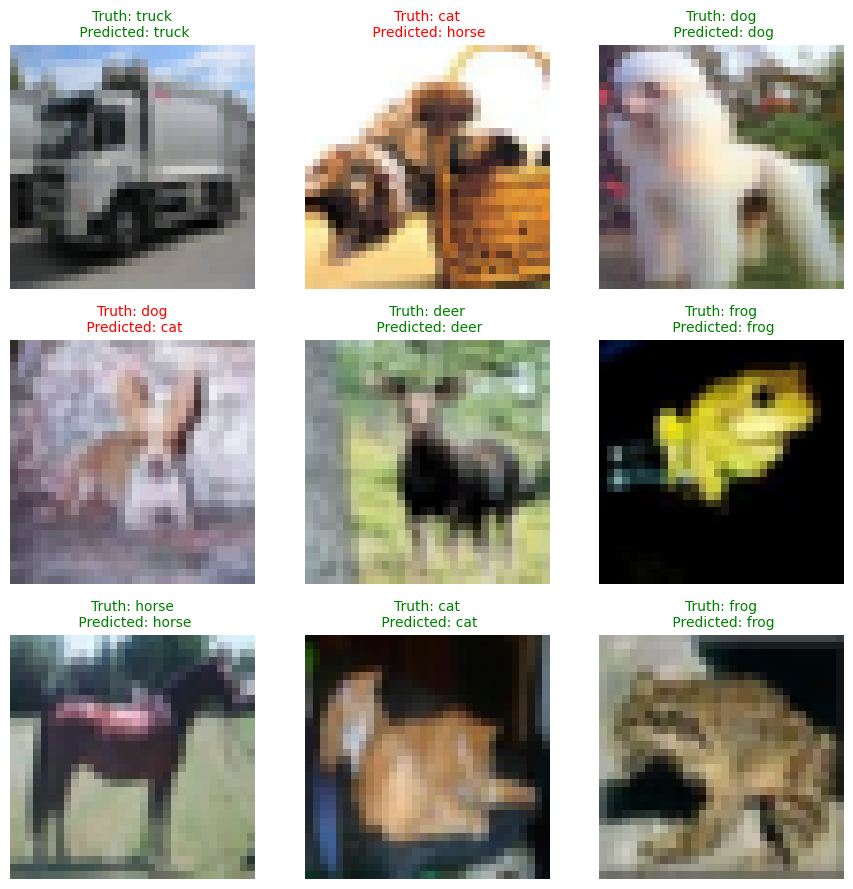

In [28]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)

## To Fine-Tune the Model
- Train on more epochs(30-50) to get higher accuracy
- Increase NUM_HEADS to get more context about the image and hence increase the accuracy {**Make sure that the number of head must divide the EMBED_DIM**}